In [38]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [39]:
# loading raw dataset
df = pd.read_csv("../data/raw/telecom_customer_churn.csv")
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [40]:
df["Customer ID"].duplicated().sum()

np.int64(0)

In [41]:
# inspecting dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [42]:
df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

In [43]:
# customer who did not suscribe phone or internet services will have '0' avg monthly call or data charges
df["Avg Monthly Long Distance Charges"] = df["Avg Monthly Long Distance Charges"].fillna(0)
df["Avg Monthly GB Download"] = df["Avg Monthly GB Download"].fillna(0)

In [44]:
# customer who have not churned or  just joined (active) will have neither churn category or reason,
# their coresponding missing values are filled with "Not churned"
churn_column_fillna = ["Churn Category", "Churn Reason"]
df[churn_column_fillna] = df[churn_column_fillna].fillna("Not churned")

# all other categorical data with missing values are filled with "Unknown", as their status cannot be determined
column_fillna = ["Offer", "Multiple Lines", "Internet Type", "Online Security", "Online Backup",
                 "Device Protection Plan", "Premium Tech Support", "Streaming TV", "Streaming Movies",
                "Streaming Music", "Unlimited Data"]
df[column_fillna] = df[column_fillna].fillna("Unknown")

In [45]:
df.isnull().sum()

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

In [46]:
# validating logical consistency
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    if (df[col] < 0).any():
        print(f"Negative values found in {col}")

Negative values found in Longitude
Negative values found in Monthly Charge


In [47]:
# dropping rows where monthly charge = 0
df = df[df["Monthly Charge"] > 0]

In [48]:
df = df[df["Tenure in Months"] > 0]

In [49]:
df["Calculated Charges"] = df["Monthly Charge"] * df["Tenure in Months"]

df["Charges Difference"] = abs(df["Total Charges"] - df["Calculated Charges"])

df["Charges Difference"].describe()

count    6923.000000
mean       44.949190
std        49.710033
min         0.000000
25%         9.400000
50%        28.500000
75%        63.550000
max       373.250000
Name: Charges Difference, dtype: float64

In [50]:
# managing logical in consisitency in total revenue
Q1 = df["Charges Difference"].quantile(0.25)
Q3 = df["Charges Difference"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = round((Q3 + 1.5 * IQR), 0)
upper_bound

np.float64(145.0)

In [51]:
df[df["Charges Difference"] > 145].shape

(355, 40)

In [52]:
df.groupby("Contract")["Tenure in Months"].describe()

,count,mean,std,min,25%,50%,75%,max
Contract,,,,,,,,
Month-to-Month,3549.0,17.396731,17.346715,1.0,3.0,11.0,27.0,72.0
One Year,1520.0,41.414474,19.255650,1.0,26.0,43.0,58.0,72.0
Two Year,1854.0,53.849515,20.280880,1.0,43.0,62.0,71.0,72.0


In [53]:
df[
    (df["Phone Service"] == "No") &
    (df["Multiple Lines"] == "Yes")
]

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Calculated Charges,Charges Difference


In [54]:
df.groupby("Customer Status")["Tenure in Months"].describe()

,count,mean,std,min,25%,50%,75%,max
Customer Status,,,,,,,,
Churned,1839.0,18.113105,19.611661,1.0,2.0,10.0,29.0,72.0
Joined,448.0,1.720982,0.819400,1.0,1.0,1.0,2.0,3.0
Stayed,4636.0,41.080026,22.347850,4.0,21.0,42.0,63.0,72.0


In [55]:
# checking for ouliers in "Total Revenue"
num_cols = df[["Total Revenue"]]
q1 = num_cols.quantile(0.25)
q3 = num_cols.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = ((num_cols < lower_bound) | (num_cols > upper_bound))
outliers.sum()

Total Revenue    21
dtype: int64

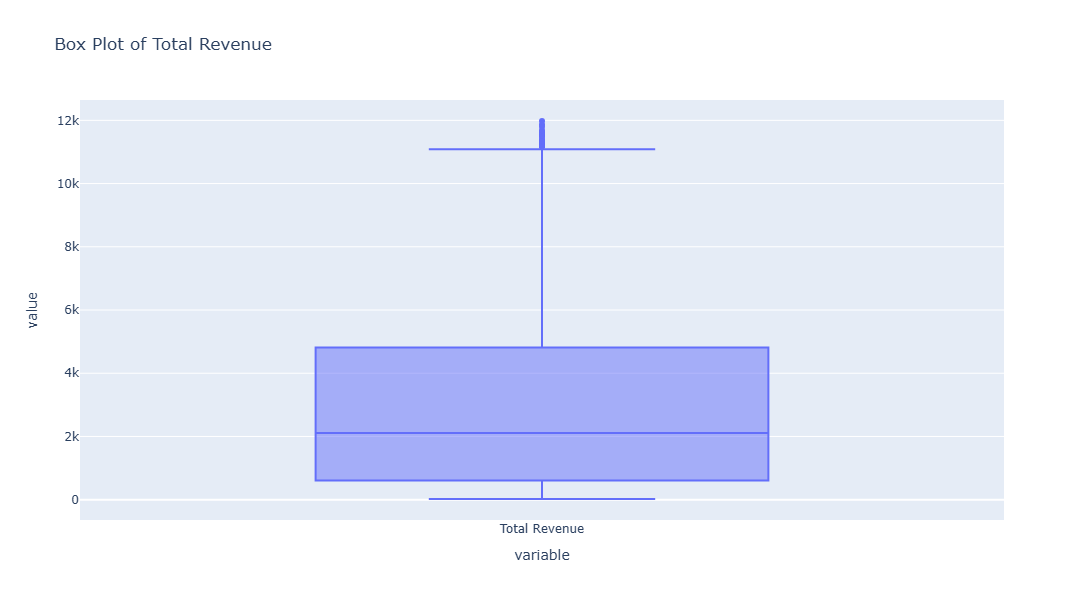

In [56]:
# using boxplot to visualize oulier for the "Total Revenue" feature
fig = px.box(
    df,
    y=["Total Revenue"],
    title="Box Plot of Total Revenue ",
    width=600,
    height=600
    # yaxis_title= "Numerical Features",
    # vert=False
)
fig.show()

In [57]:
# since all of the ouliers are above the 10_000, Total Revenue above the 10_000 is filterd and the rows are dropped
df = df[df["Total Revenue"] <= 10_000]

# outlier check
num_cols = df[["Total Revenue"]]
q1 = num_cols.quantile(0.25)
q3 = num_cols.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = ((num_cols < lower_bound) | (num_cols > upper_bound))
outliers.sum()

Total Revenue    0
dtype: int64

In [59]:
unreq_features = {
    "Zip Code",
    "Latitude",
    "Longitude",
    "Avg Monthly Long Distance Charges",
    "Avg Monthly GB Download",
    "Total Refunds",
    "Total Extra Data Charges",
    "Total Long Distance Charges"
}

df.drop(columns=unreq_features, inplace=True)

In [60]:
df.to_csv("../data/cleaned/cleaned_telecom_customer_churn.csv", index=False)